In [1]:
import numpy as np
from scipy.stats import bernoulli
from scipy.stats import beta
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
from PIL import Image
import glob
import re

plt.rcParams['text.usetex'] = True

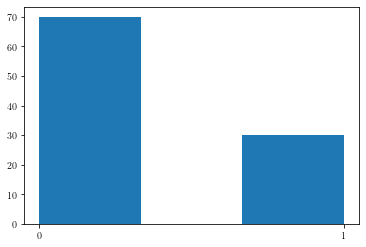

In [2]:
np.random.seed(414)

#真の分布． μ = 0.3 とする．
mu = 0.3
# サンプル数 = 100
data = bernoulli.rvs(mu, size=100)

fig, ax = plt.subplots()
ax.set_xticks([0, 1])
ax.hist(data, bins=3);

## ・事前分布  
事前分布はベルヌーイ分布の共役事前分布であるベータ分布を使用する．

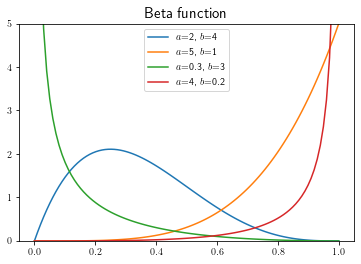

In [3]:
#ベータ分布のパラメータ
param = [(2, 4), (5, 1), (0.3, 3), (4, 0.2)]

fig, ax = plt.subplots()
ax.set_title('Beta function', size=15)
ax.set_ylim(0, 5)

x = np.linspace(0, 1, 100)

for a, b in param:
    f = beta.pdf(x, a, b)
    ax.plot(x, f, label= fr'$a$={a}, $b$={b}');
ax.legend()

## ・事後分布推定

In [4]:
def inference_posterior_proba(data, a, b):
    N = len(data)
    a_hat = data.sum() + a
    b_hat = N - data.sum() + b
    return a_hat, b_hat

学習させるデータ数が増えるほど μ = 0.3 あたりで尖っていく様子が伺える．  

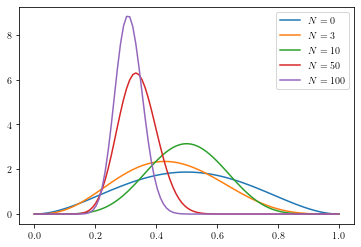

In [5]:
#事後分布がデータ数に対してどのように変化するかを観察したい
np.random.seed(414)
N = [0, 3, 10, 50, 100]
fig, ax = plt.subplots()

x = np.linspace(0, 1, 100)
datas = bernoulli.rvs(mu, size=100)

for n in N:
    data = datas[:n]
    a_hat, b_hat = inference_posterior_proba(data, a=3, b=3)
    f = beta.pdf(x, a_hat, b_hat)
    
    ax.plot(x, f, label=fr'$N = {n}$')
ax.legend()

### ・訓練データの数に応じた事後分布の変化の様子を動画にする

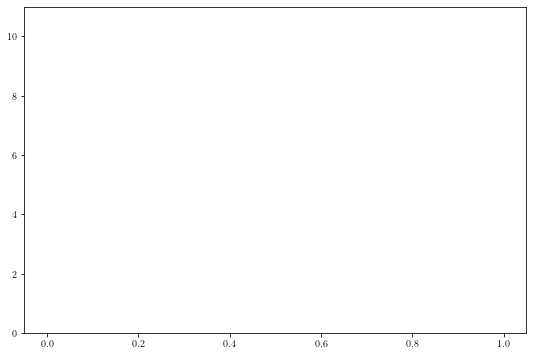

In [29]:
np.random.seed(414)

x = np.linspace(0, 1, 100)
datas = bernoulli.rvs(mu, size=100)

ims = []
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylim(0, 11)
ax.set_yticks([0, 2, 4, 6, 8, 10])

for n in range(0, 101):
    data = datas[:n]
    a_hat, b_hat = inference_posterior_proba(data, a=3, b=3)
    f = beta.pdf(x, a_hat, b_hat)
    
    #ax.set_title(fr'$N={n}$')
    im = ax.plot(x, f, color='b')
    ims.append(im)
    
ani = animation.ArtistAnimation(fig, ims, interval=100)
ani.save("./posterior.gif", writer="imagemagick")

### ・matplotlib.animationで描画しようと思ったけど， 図タイトルの変化がうまく反映さないため，一旦画像を出力して， その後，gifにする．
Pillow 7.0.0 を使用．  
Pillow 7.1.1ではgifにできなかった．

[参考]  
・Cannot write a GIF file: https://github.com/python-pillow/Pillow/issues/4543 [閲覧日:2020/4/16]  
・Python PillowでPNGからGIFを作る： https://qiita.com/hiro9/items/222bea3e77dfed235f0a [閲覧日：2020/4/16]  
・【Python】ファイル名の数字順にソート（自然順ソート）する方法： https://tane-no-blog.com/761/ [閲覧日:2020/4/16]

In [19]:
os.makedirs('./fig', exist_ok=True)

np.random.seed(414)

x = np.linspace(0, 1, 100)
datas = bernoulli.rvs(mu, size=100)

for n in range(101):
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_ylim(0, 11)
    ax.set_yticks([0, 2, 4, 6, 8, 10])
    
    data = datas[:n]
    a_hat, b_hat = inference_posterior_proba(data, a=3, b=3)
    f = beta.pdf(x, a_hat, b_hat)
    ax.set_title(fr'$N = {n}$')
    ax.plot(x, f)
    fig.savefig(f'./fig/{n}_fig.png', dpi=150)
    plt.close(fig)

In [9]:
files = sorted(glob.glob('./fig/*.png'), key=lambda path: int(re.sub('\\D', '', path)))
images = list(map(lambda file:Image.open(file), files))
images[0].save('posterior.gif', save_all=True, append_images=images[1:], duration=130, loop=0)

## ・予測分布
予測分布から100点サンプルする．

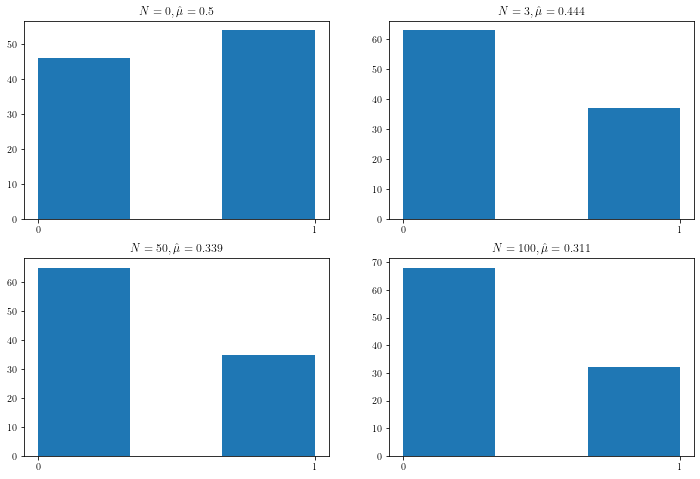

In [31]:
np.random.seed(414)
N = [0, 3, 50, 100]
fig = plt.figure(figsize=(12, 8))

x = np.linspace(0, 1, 100)
#学習させるデータ
datas = bernoulli.rvs(mu, size=100)

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

axs = [ax1, ax2, ax3, ax4]

for n, ax in zip(N, axs):
    data = datas[:n]
    #事後分布推定
    a_hat, b_hat = inference_posterior_proba(data, a=3, b=3)
    #事後分布からベルヌーイ分布のパラメータを推定
    mu_hat = a_hat/(a_hat + b_hat)
    #予測分布から100点サンプル
    X_hat = bernoulli.rvs(mu_hat, size=100)
    mu_hat = np.round(mu_hat, decimals=3)
    
    #プロット
    ax.set_title(fr'$N={n},\hat \mu={mu_hat}$')
    ax.set_xticks([0, 1])
    ax.hist(X_hat, bins=3)